In [7]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%cd ..
from src.utils import load_config
from src.data_loader import OccupancyData
%cd -

/workspaces/hospitalization-model
/workspaces/hospitalization-model/notebooks


In [8]:
dates = load_config("../config/150_dates.yaml")["dates"]
print(dates)

['2020-12-15', '2020-12-19', '2020-12-23', '2020-12-27', '2021-01-01', '2021-01-05', '2021-01-09', '2021-01-14', '2021-01-18', '2021-01-22', '2021-01-26', '2021-01-31', '2021-02-04', '2021-02-08', '2021-02-13', '2021-02-17', '2021-02-21', '2021-02-25', '2021-03-02', '2021-03-06', '2021-03-10', '2021-03-15', '2021-03-19', '2021-03-23', '2021-03-27', '2021-04-01', '2021-04-05', '2021-04-09', '2021-04-14', '2021-04-18', '2021-04-22', '2021-04-26', '2021-05-01', '2021-05-05', '2021-05-09', '2021-05-14', '2021-05-18', '2021-05-22', '2021-05-26', '2021-05-31', '2021-06-04', '2021-06-08', '2021-06-13', '2021-06-17', '2021-06-21', '2021-06-25', '2021-06-30', '2021-07-04', '2021-07-08', '2021-07-13', '2021-07-17', '2021-07-21', '2021-07-26', '2021-07-30', '2021-08-03', '2021-08-07', '2021-08-12', '2021-08-16', '2021-08-20', '2021-08-25', '2021-08-29', '2021-09-02', '2021-09-06', '2021-09-11', '2021-09-15', '2021-09-19', '2021-09-24', '2021-09-28', '2021-10-02', '2021-10-06', '2021-10-11', '2021

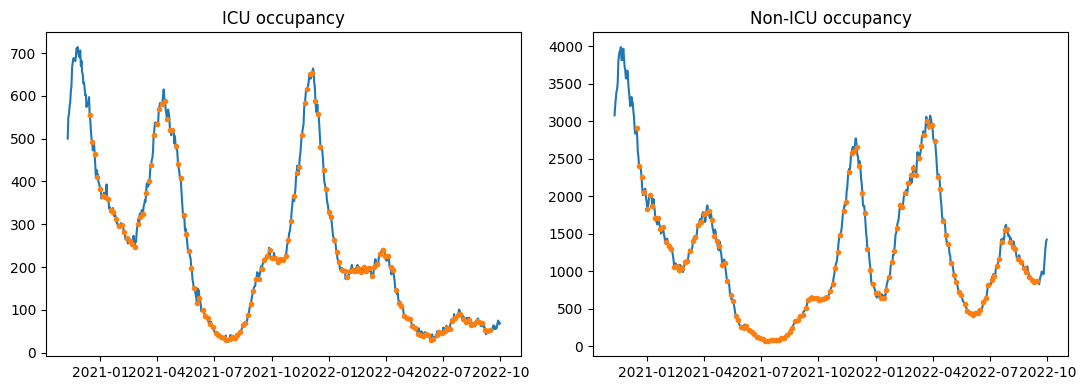

In [9]:
data = OccupancyData("../data/hospitalization.csv")
icu = data.get_df("2020-11-10", "2022-10-01", "Österreich", "ICU")
normal = data.get_df("2020-11-10", "2022-10-01", "Österreich", "normal")
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].plot(icu)
ax[0].plot(icu.loc[dates],linestyle="",marker="o", markersize=3)
ax[0].set_title("ICU occupancy")
ax[1].plot(normal)
ax[1].plot(normal.loc[dates],linestyle="",marker="o", markersize=3)
ax[1].set_title("Non-ICU occupancy")
plt.tight_layout()
plt.savefig("plots/150dates.pdf")

In [10]:
with open(os.path.join("../benchmarks", f"causal_model.json")) as f:
    benchmark = json.load(f)
    mase = []
    mape = []
    calibration = []
    for date in benchmark["successful_forecasts"]:
        mase.append(benchmark["successful_forecasts"][date]["mase"])
        mape.append(benchmark["successful_forecasts"][date]["mape"])
        calibration.append(benchmark["successful_forecasts"][date]["calibration_stats"]["mape"])
print("Mean MASE: ", np.mean(mase))
print("Mean MAPE: ", np.mean(mape))
print("Standard deviation MASE: ", np.std(mase))
print("Standard deviation MAPE: ", np.std(mape))
print("Mean calibration MAPE: ", np.mean(calibration))

Mean MASE:  4.1707882844294835
Mean MAPE:  15.40278438879675
Standard deviation MASE:  5.928188310942641
Standard deviation MAPE:  17.422097426035535
Mean calibration MAPE:  1.9897156112593413


In [11]:
with open(os.path.join("../benchmarks", f"arima_model.json")) as f:
    benchmark = json.load(f)
    mase = []
    mape = []
    parameters = []
    for date in benchmark["successful_forecasts"]:
        mase.append(benchmark["successful_forecasts"][date]["mase"])
        mape.append(benchmark["successful_forecasts"][date]["mape"])
        order = benchmark["successful_forecasts"][date]["calibration_stats"]["order"]
        seasonal_order = benchmark["successful_forecasts"][date]["calibration_stats"]["seasonal_order"]
        parameters.append(order + seasonal_order)
print("Mean MASE: ", np.mean(mase))
print("Mean MAPE: ", np.mean(mape))
print("Standard deviation MASE: ", np.std(mase))
print("Standard deviation MAPE: ", np.std(mape))
df = pd.DataFrame(parameters, columns=["p", "d", "q", "P", "D", "Q", "s"])
df = df.groupby(df.columns.tolist(),as_index=False).size().sort_values(by="size", ascending=False).drop("s", axis=1)
df["name"] = df.agg('({0[p]},{0[d]},{0[q]}) x ({0[P]},{0[D]},{0[Q]})'.format, axis=1)
df.style.hide(axis='index')

Mean MASE:  3.8787611627728515
Mean MAPE:  18.25590051780181
Standard deviation MASE:  3.1282478456386915
Standard deviation MAPE:  24.279225452055428


p,d,q,P,D,Q,size,name
2,1,1,2,0,0,86,"(2,1,1) x (2,0,0)"
2,1,1,1,0,2,26,"(2,1,1) x (1,0,2)"
2,1,1,2,0,1,11,"(2,1,1) x (2,0,1)"
3,0,1,0,0,2,4,"(3,0,1) x (0,0,2)"
3,0,1,1,0,0,3,"(3,0,1) x (1,0,0)"
1,1,2,1,0,2,2,"(1,1,2) x (1,0,2)"
2,0,2,1,0,0,2,"(2,0,2) x (1,0,0)"
2,0,2,1,0,1,2,"(2,0,2) x (1,0,1)"
2,1,0,0,0,0,1,"(2,1,0) x (0,0,0)"
3,0,1,0,0,1,1,"(3,0,1) x (0,0,1)"


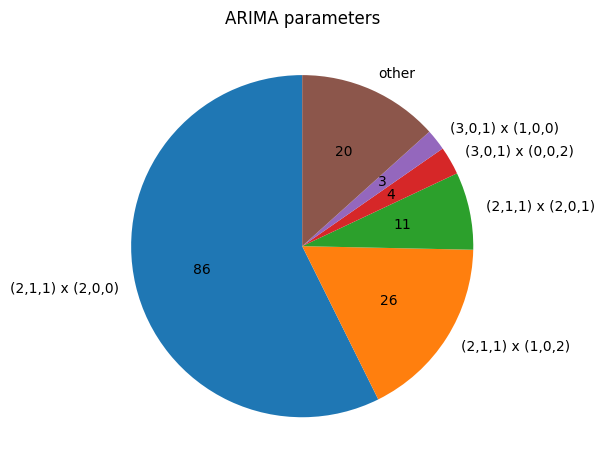

In [12]:
threshold = 3
show = df[df["size"] >= threshold]
other_sum = df[df["size"] < threshold]["size"].sum()
total = df["size"].sum()
plt.pie(show["size"].to_list() + [other_sum], labels=show["name"].to_list() + ["other"], startangle=90, autopct=lambda p: '{:.0f}'.format(p * total / 100))
plt.title("ARIMA parameters")
plt.tight_layout()
plt.savefig("plots/arima_parameters.pdf")
plt.show()